<a href="https://colab.research.google.com/github/malikwaqas077/Real-Time-AI-Sentinel-for-Robotic-Weld-Quality/blob/main/Metal_Arc_Welding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet optuna shap onnx onnxruntime==1.17.1 imbalanced-learn torchinfo


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Welding_Dataset/processed_asimow_dataset.csv')

In [ ]:
df.head()

,experiment,welding_run,labels,V_0,V_1,V_2,V_3,V_4,V_5,V_6,...,I_190,I_191,I_192,I_193,I_194,I_195,I_196,I_197,I_198,I_199
0,1,2,-1,14.721354,15.633854,16.217187,16.810417,17.386458,17.799479,18.291146,...,24.674479,24.414063,24.934896,25.195313,24.088542,24.088542,24.609375,24.739583,25.130208,23.632813
1,1,2,-1,13.944792,14.313021,15.043750,15.823437,16.233333,16.706250,17.156250,...,49.934896,48.372396,48.502604,48.893229,49.609375,50.195313,48.632813,48.372396,48.632813,49.869792
2,1,2,-1,1.329167,1.756771,2.232292,2.483333,2.867187,3.166667,3.348437,...,27.018229,27.018229,27.408854,26.497396,26.302083,26.236979,27.539063,27.539063,26.692708,26.888021
3,1,2,-1,14.666667,15.091146,16.007292,16.548437,17.211979,17.594271,17.983333,...,104.036458,107.682292,109.570313,112.890625,115.885417,119.335938,122.200521,123.828125,127.148438,130.013021
4,1,2,-1,3.323958,3.566146,4.114583,4.458333,4.853646,5.204167,5.573958,...,26.302083,26.171875,26.627604,27.278646,27.929688,26.367188,26.822917,27.148438,27.408854,27.604167


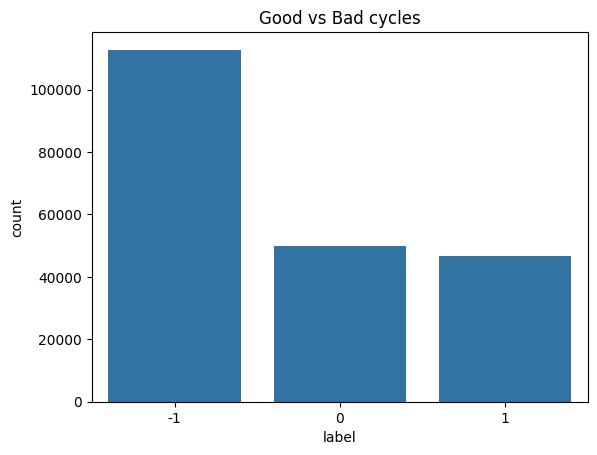

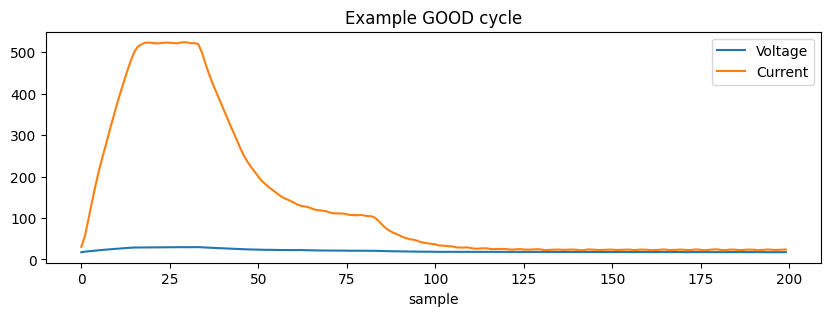

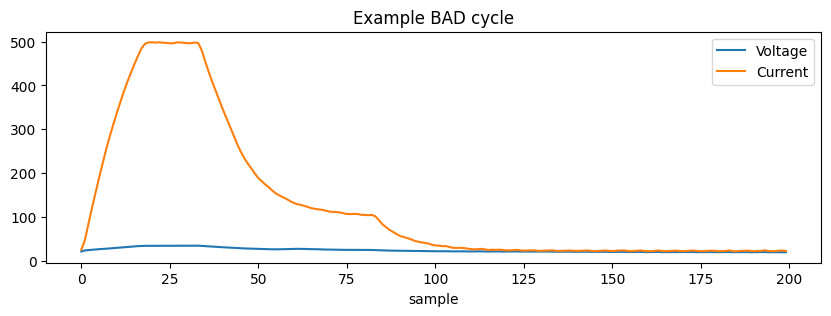

In [ ]:
import seaborn as sns, matplotlib.pyplot as plt

# label distribution
sns.countplot(x='label', data=df.rename(columns={'labels':'label'}))
plt.title('Good vs Bad cycles'); plt.show()

# voltage trace of first good & bad cycle
good_idx = df.query('labels==1').index[0]
bad_idx  = df.query('labels==0').index[0]

def plot_cycle(idx, title):
    v = df.loc[idx, [f'V_{i}' for i in range(200)]].values
    i_ = df.loc[idx, [f'I_{i}' for i in range(200)]].values
    plt.figure(figsize=(10,3))
    plt.plot(v, label='Voltage'); plt.plot(i_, label='Current')
    plt.title(title); plt.xlabel('sample'); plt.legend(); plt.show()

plot_cycle(good_idx, 'Example GOOD cycle')
plot_cycle(bad_idx , 'Example BAD cycle')


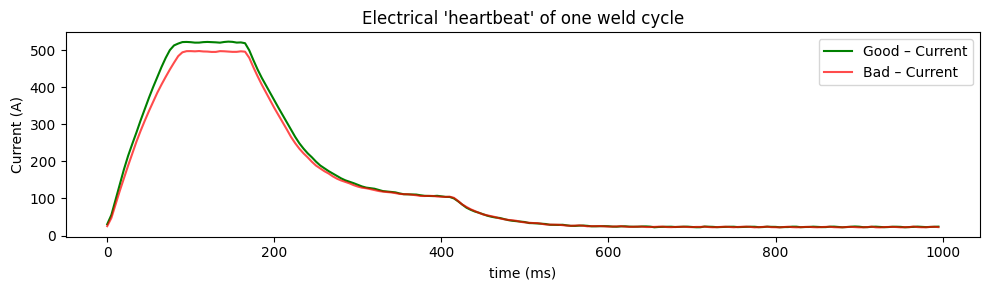

In [ ]:
# --- parameters so the axis is in real time --------------------
SAMPLES = 200               # points in the processed file
RAW_HZ  = 100_000           # original sampling rate in paper
#  They down-sampled: 100 kHz → 200 pts  ⇒  each point ≈ 0.0004 s
ms_per_point = (1/RAW_HZ) * (100_000/SAMPLES) * 1000  # ≈0.4 ms
t = np.arange(SAMPLES) * ms_per_point

# --- plot good vs bad on one figure ----------------------------
plt.figure(figsize=(10,3))
plt.plot(t, df.loc[good_idx,[f'I_{i}' for i in range(200)]],
         color='green',  label='Good – Current')
plt.plot(t, df.loc[bad_idx, [f'I_{i}' for i in range(200)]],
         color='red',    label='Bad – Current', alpha=.7)
plt.title("Electrical 'heartbeat' of one weld cycle")
plt.xlabel("time (ms)"); plt.ylabel("Current (A)")
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# keep only labelled rows (drop -1)
df_lab = df.query('labels!=-1').copy()
y      = df_lab['labels'].astype(int).values   # 0 = bad, 1 = good
Xv     = df_lab[[f'V_{i}' for i in range(200)]].values
Xi     = df_lab[[f'I_{i}' for i in range(200)]].values
X      = np.stack([Xv, Xi], axis=2)            # shape: (n, 200, 2)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.mean())


(77126, 200, 2) 0.48405207063765787


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import classification_report_imbalanced

X_flat = X.reshape(len(X), -1)          # RF needs 2-D

X_tr, X_te, y_tr, y_te = train_test_split(
    X_flat, y, stratify=y, test_size=0.2, random_state=42)

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('balance', RandomOverSampler()),   # handle class imbalance
    ('rf', RandomForestClassifier(n_estimators=400, n_jobs=-1,
                                  class_weight='balanced'))
])
pipe.fit(X_tr, y_tr)
pred = pipe.predict(X_te)
print(classification_report(y_te, pred))
print('F1:', f1_score(y_te, pred))


              precision    recall  f1-score   support

           0       0.85      0.86      0.85      9949
           1       0.85      0.83      0.84      9333

    accuracy                           0.85     19282
   macro avg       0.85      0.84      0.85     19282
weighted avg       0.85      0.85      0.85     19282

F1: 0.8389812216706238


In [ ]:
# ---------- PREP (same as before) ----------
df_lab = df.query('labels!=-1').copy()
y      = df_lab['labels'].astype(int).values
V = df_lab[[f'V_{i}' for i in range(120)]].values   # CROP to 120 pts
I = df_lab[[f'I_{i}' for i in range(120)]].values
X = np.stack([V,I], axis=2).astype(np.float32)

# z-score
X = (X - X.mean(axis=(0,1),keepdims=True)) / (X.std(axis=(0,1),keepdims=True)+1e-6)

X_tr, X_tmp, y_tr, y_tmp = train_test_split(X,y,test_size=0.4,stratify=y,random_state=42)
X_val, X_te, y_val, y_te = train_test_split(X_tmp,y_tmp,test_size=0.5,stratify=y_tmp,random_state=42)

to_loader = lambda X,y,bs,sh: DataLoader(TensorDataset(torch.tensor(X),
                                                       torch.tensor(y,dtype=torch.float32)),
                                         bs, shuffle=sh, drop_last=True)
train_loader = to_loader(X_tr,y_tr,512,True)
val_loader   = to_loader(X_val,y_val,1024,False)
test_loader  = to_loader(X_te,y_te,1024,False)

# ---------- CLASS WEIGHT ----------
cls_w = compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
pos_w = torch.tensor(cls_w[1], dtype=torch.float32).to('cuda' if torch.cuda.is_available() else 'cpu')

# ---------- MODEL ----------
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Conv1d(2,32,7,padding=3), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32,64,5,padding=2), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64,128,3,padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1), nn.Flatten())
        self.head = nn.Sequential(nn.Dropout(0.3), nn.Linear(128,1))
    def forward(self,x):
        x = x.permute(0,2,1)
        return self.head(self.feat(x)).squeeze(1)   # logits

device='cuda' if torch.cuda.is_available() else 'cpu'
model=ConvNet().to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_w)
opt     = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
sched   = torch.optim.lr_scheduler.CosineAnnealingLR(opt,T_max=20,eta_min=3e-5)

best, patience = 0,0
for epoch in range(30):
    model.train()
    for xb,yb in train_loader:
        xb,yb=xb.to(device), yb.to(device)
        opt.zero_grad(); loss=loss_fn(model(xb), yb); loss.backward(); opt.step()
    sched.step()

    # validation
    model.eval(); pr, ys = [], []
    with torch.no_grad():
        for xb,yb in val_loader:
            logits = model(xb.to(device))
            pr.extend((torch.sigmoid(logits)>0.5).cpu().numpy())
            ys.extend(yb.numpy())
    f1 = f1_score(ys,pr); print(f'E{epoch+1:02d} F1={f1:.3f}')
    if f1>best: best,patience=f1,0; torch.save(model.state_dict(),'cnn.pt')
    else:
        patience+=1
        if patience==6: break

# ---------- TEST ----------
model.load_state_dict(torch.load('cnn.pt')); model.eval()
pr,ys=[],[]
with torch.no_grad():
    for xb,yb in test_loader:
        pr.extend((torch.sigmoid(model(xb.to(device)))>0.5).cpu().numpy()); ys.extend(yb.numpy())
print('Test F1:', round(f1_score(ys,pr),3))


E01 F1=0.686
E02 F1=0.671
E03 F1=0.693
E04 F1=0.693
E05 F1=0.719
E06 F1=0.708
E07 F1=0.716
E08 F1=0.709
E09 F1=0.708
E10 F1=0.707
E11 F1=0.714
Test F1: 0.714
